In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import re
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, LSTM
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D

In [ ]:
class UkStemmer():
    ''' Allows you to perform stemming of words of the Ukrainian language (that is, obtaining the basis of the word).
    Contains a single stem_word() method.

    Is a slightly 'groomed' version of the stemmer from Amice13: https://github.com/Amice13/ukr_stemmer '''
    def __init__(self):
        # http://uk.wikipedia.org/wiki/Голосний_звук
        self.vowel = r'аеиоуюяіїє'
        self.perfectiveground = r'(ив|ивши|ившись|ыв|ывши|ывшись((?<=[ая])(в|вши|вшись)))$'
        # http://uk.wikipedia.org/wiki/Рефлексивне_дієслово
        self.reflexive = r'(с[яьи])$'
        # http://uk.wikipedia.org/wiki/Прикметник + http://wapedia.mobi/uk/Прикметник
        self.adjective = r'(ими|ій|ий|а|е|ова|ове|ів|є|їй|єє|еє|я|ім|ем|им|ім|их|іх|ою|йми|іми|у|ю|ого|ому|ої)$'
        # http://uk.wikipedia.org/wiki/Дієприкметник
        self.participle = r'(ий|ого|ому|им|ім|а|ій|у|ою|ій|і|их|йми|их)$'
        # http://uk.wikipedia.org/wiki/Дієслово
        self.verb = r'(сь|ся|ив|ать|ять|у|ю|ав|али|учи|ячи|вши|ши|е|ме|ати|яти|є)$'
        # http://uk.wikipedia.org/wiki/Іменник
        self.noun = r'(а|ев|ов|е|ями|ами|еи|и|ей|ой|ий|й|иям|ям|ием|ем|ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я|і|ові|ї|ею|єю|ою|є|еві|ем|єм|ів|їв|ю)$'
        self.rvre = r'[аеиоуюяіїє]'
        self.derivational = r'[^аеиоуюяіїє][аеиоуюяіїє]+[^аеиоуюяіїє]+[аеиоуюяіїє].*(?<=о)сть?$'
        self.RV = ''


    def __ukstemmer_search_preprocess(self, word):
        word = word.lower()
        word = word.replace("'", "")
        word = word.replace("ё", "е")
        word = word.replace("ъ", "ї")
        return word


    def __s(self, st, reg, to):
        orig = st
        self.RV = re.sub(reg, to, st)
        return (orig != self.RV)


    def stem_word(self, word):
        ''' Find the basis (stem) of a word.
        1. word - source word (UTF-8 encoded string)
        2. returns the stemmed form of the word (UTF-8 encoded string) '''

        word = self.__ukstemmer_search_preprocess(word)
        if not re.search('[аеиоуюяіїє]', word):
            stemma = word
        else:
            p = re.search(self.rvre, word)
            start = word[0:p.span()[1]]
            self.RV = word[p.span()[1]:]

            # Step 1
            if not self.__s(self.RV, self.perfectiveground, ''):

                self.__s(self.RV, self.reflexive, '')
                if self.__s(self.RV, self.adjective, ''):
                    self.__s(self.RV, self.participle, '')
                else:
                    if not self.__s(self.RV, self.verb, ''):
                        self.__s(self.RV, self.noun, '')
            # Step 2
            self.__s(self.RV, 'и$', '')

            # Step 3
            if re.search(self.derivational, self.RV):
                self.__s(self.RV, 'ость$', '')

            # Step 4
            if self.__s(self.RV, 'ь$', ''):
                self.__s(self.RV, 'ейше?$', '')
                self.__s(self.RV, 'нн$', u'н')

            stemma = start + self.RV
        return stemma


    def stemWord(self, word):
        ''' Find the basis (stem) of a word.
        1. word - source word (UTF-8 encoded string)
        2. returns the stemmed form of the word (UTF-8 encoded string)

        This method is used to simulate the PyStemmer interface (https://github.com/snowballstem/pystemmer). '''

        return self.stem_word(word)

In [ ]:
stemmer = UkStemmer()

In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import json
import ast

In [ ]:
with open('stopwords_ua_list.txt', 'r', encoding="utf-8") as file:
    content = file.read()

# Parse the content as a Python literal
stopwords = ast.literal_eval(content)

In [ ]:
def sentence_preprocess(row):
    sentence = row["title"]
    sentence = ' '.join(simple_preprocess(sentence))
    words = word_tokenize(sentence)

    words = [w for w in words if w not in stopwords]

    for i in range(len(words)):
        words[i] = stemmer.stem_word(words[i])
    return ' '.join(words)

In [ ]:
df = pd.read_csv("train.csv")

In [ ]:
df["title_stemmed"] = df.apply(sentence_preprocess, 1)

In [ ]:
df

,title,text,tags,target,title_stemmed
0,"ВЕРНИДУБ: «Наносимо 25 ударів, 15 у ворота, а ...",Головний тренер солігорського «Шахтаря» Юрій В...,Футбол|Інші новини|Шахтар Солігорськ|Юрій Верн...,спорт,вернидуб наносим удар ворот забит сумн
1,"У ""Київстар"" заявляють, що їх обшукала ДФС",Про це на своїй сторінці у Facebook написав пр...,|Київстар|Новини|податкова|ДФС|обшук|,новини,київстар заявляют обшукал дфс
2,В 2016 році 1% найзаможніших людей вперше ста...,Про це повідомляється в доповіді некомерційної...,|багатство|найбагатші люди світу|Новини|бідність|,новини,найзаможніш люд вперш стан багатш
3,Шакіл О’Ніл продав шикарний маєток у Флориді в...,Легенда НБА Шакіл О’Ніл продав свій маєток у ...,США|Баскетбол|Флорида|Фото,спорт,шакіл ніл прод шикарн маєток флорид вартіст мл...
4,"У «заблокованій» СБУ B2B Jewelry заявили, що п...",Засновник фінансової піраміди B2B Jewelry Мик...,Служба безпеки України (СБУ)|Финансовая пирами...,бізнес,заблокован сбу jewelry заявил працюют звичайн ...
...,...,...,...,...,...
120412,Моряка Ейдера могли заразити гепатитом під ча...,Про це заявила Уповноважена Верховної Ради Укр...,|Керченська протока|Людмила Денісова|Андрій Ей...,новини,моряк ейдер заразит гепатит операці деніс
120413,"""Укргазвидобування"" працює в інтересах російс...",Про це сьогодні на брифінгу у Верховній Раді з...,|Михайло Головко|Росія|Новини|Укргазвидобування|,політика,працю інтерес російськ спецслужб головк
120414,До 300 Мвт на годину. Україна відновила імпорт...,України 1 лютого почала здійснювати імпорт ел...,Енергетика|Електроенергія,бізнес,мвт годин україн відновил імпорт електроенергі рф
120415,"Берлусконі каже, що анексія Криму була ""демок...",Про це повідомляє Еспресо.TV з посиланням на R...,|анексія Криму|Росія|Сільвіо Берлусконі|Новини...,політика,берлускон анекс крим демократичн путін номер світ


In [ ]:
label_encoder = LabelEncoder()
df["target_encoded"] = label_encoder.fit_transform(df["target"])
target_dict = dict(zip(df['target_encoded'], df['target']))

In [ ]:
df.drop(["title", "text", "tags", "target"], axis=1, inplace=True)

In [ ]:
df.to_csv("stemmed_data.csv", index=False)

In [ ]:
df

,title_stemmed,target_encoded
0,вернидуб наносим удар ворот забит сумн,3
1,київстар заявляют обшукал дфс,1
2,найзаможніш люд вперш стан багатш,1
3,шакіл ніл прод шикарн маєток флорид вартіст мл...,3
4,заблокован сбу jewelry заявил працюют звичайн ...,0
...,...,...
120412,моряк ейдер заразит гепатит операці деніс,1
120413,працю інтерес російськ спецслужб головк,2
120414,мвт годин україн відновил імпорт електроенергі рф,0
120415,берлускон анекс крим демократичн путін номер світ,2


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding, Conv1D, MaxPooling1D
from keras.models import Model
import io
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving stemmed_data.csv to stemmed_data.csv


In [ ]:
df = pd.read_csv(io.StringIO(uploaded['stemmed_data.csv'].decode('utf-8')))

In [ ]:
#df = pd.read_csv("stemmed_data.csv")
df.dropna(inplace=True)

In [ ]:
texts = df['title_stemmed'].values
labels = df['target_encoded'].values

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [ ]:
max_seq_length = max(len(seq) for seq in train_sequences)
train_sequences = pad_sequences(train_sequences, maxlen=max_seq_length, padding="post")
test_sequences = pad_sequences(test_sequences, maxlen=max_seq_length, padding="post")

vocab_size = len(tokenizer.word_index) + 1
embedding_size = 100
num_classes = 5

# First model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_seq_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 100)           4005500   
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_2 (Dense)             (None, 24)                2424      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 125       
                                                                 
Total params: 4008049 (15.29 MB)
Trainable params: 4008049 (15.29 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
batch_size = 64
epochs = 5
with tf.device('/GPU:0'):
    history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_sequences, test_labels))

Epoch 1/5
1506/1506 [==============================] - 98s 64ms/step - loss: 0.6681 - accuracy: 0.7502 - val_loss: 0.3409 - val_accuracy: 0.8756
Epoch 2/5
1506/1506 [==============================] - 88s 58ms/step - loss: 0.2911 - accuracy: 0.8979 - val_loss: 0.3089 - val_accuracy: 0.8851
Epoch 3/5
1506/1506 [==============================] - 90s 59ms/step - loss: 0.2134 - accuracy: 0.9256 - val_loss: 0.3167 - val_accuracy: 0.8842
Epoch 4/5
1506/1506 [==============================] - 92s 61ms/step - loss: 0.1704 - accuracy: 0.9410 - val_loss: 0.3403 - val_accuracy: 0.8792
Epoch 5/5
1506/1506 [==============================] - 94s 62ms/step - loss: 0.1408 - accuracy: 0.9510 - val_loss: 0.3652 - val_accuracy: 0.8780


In [ ]:
loss, accuracy = model.evaluate(test_sequences, test_labels)

753/753 [==============================] - 1s 2ms/step - loss: 0.3652 - accuracy: 0.8780


In [ ]:
predictions = model.predict(test_sequences)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(np.argmax(test_labels, axis=1), predicted_labels))

753/753 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      2943
           1       0.84      0.83      0.84      5134
           2       0.91      0.93      0.92      8032
           3       0.98      0.97      0.98      5674
           4       0.77      0.77      0.77      2300

    accuracy                           0.88     24083
   macro avg       0.85      0.85      0.85     24083
weighted avg       0.88      0.88      0.88     24083



array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

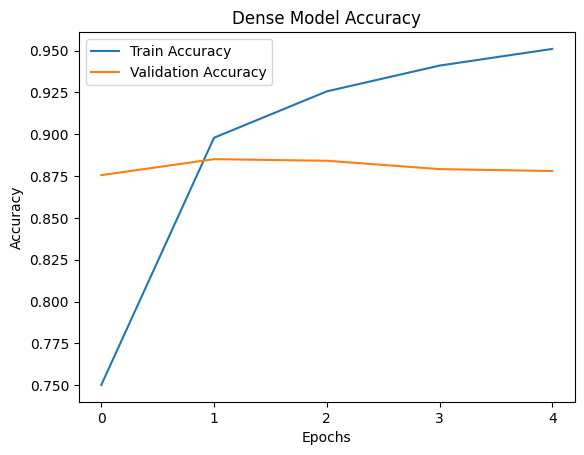

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Dense Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([0, 1, 2, 3, 4])
plt.legend()
plt.show()

# Second model

In [ ]:
model_conv = Sequential()
model_conv.add(Input(shape=(max_seq_length,)))
model_conv.add(Embedding(vocab_size, embedding_size, input_length=max_seq_length))
model_conv.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model_conv.add(BatchNormalization())
model_conv.add(MaxPooling1D(pool_size=3))
model_conv.add(Dropout(0.2))
model_conv.add(Flatten())
model_conv.add(Dense(128, activation='elu'))
model_conv.add(Dropout(0.2))
model_conv.add(Dense(num_classes, activation='softmax'))

model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 100)           4005500   
                                                                 
 conv1d (Conv1D)             (None, 20, 64)            25664     
                                                                 
 batch_normalization (Batch  (None, 20, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 6, 64)             0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 6, 64)             0         
                                                                 
 flatten (Flatten)           (None, 384)              

In [ ]:
batch_size = 64
epochs = 5
with tf.device('/GPU:0'):
    history_conv = model_conv.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_sequences, test_labels))

Epoch 1/5
1506/1506 [==============================] - 123s 80ms/step - loss: 0.4873 - accuracy: 0.8205 - val_loss: 0.3300 - val_accuracy: 0.8766
Epoch 2/5
1506/1506 [==============================] - 113s 75ms/step - loss: 0.1952 - accuracy: 0.9298 - val_loss: 0.3733 - val_accuracy: 0.8727
Epoch 3/5
1506/1506 [==============================] - 117s 78ms/step - loss: 0.1051 - accuracy: 0.9627 - val_loss: 0.4280 - val_accuracy: 0.8675
Epoch 4/5
1506/1506 [==============================] - 108s 72ms/step - loss: 0.0698 - accuracy: 0.9752 - val_loss: 0.5144 - val_accuracy: 0.8664
Epoch 5/5
1506/1506 [==============================] - 102s 68ms/step - loss: 0.0503 - accuracy: 0.9825 - val_loss: 0.6114 - val_accuracy: 0.8621


In [ ]:
loss_conv, accuracy_conv = model_conv.evaluate(test_sequences, test_labels)

753/753 [==============================] - 3s 4ms/step - loss: 0.6114 - accuracy: 0.8621


In [ ]:
predictions = model_conv.predict(test_sequences)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(np.argmax(test_labels, axis=1), predicted_labels))

753/753 [==============================] - 5s 6ms/step
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      2943
           1       0.77      0.87      0.82      5134
           2       0.92      0.89      0.91      8032
           3       0.97      0.97      0.97      5674
           4       0.74      0.73      0.74      2300

    accuracy                           0.86     24083
   macro avg       0.83      0.83      0.83     24083
weighted avg       0.86      0.86      0.86     24083



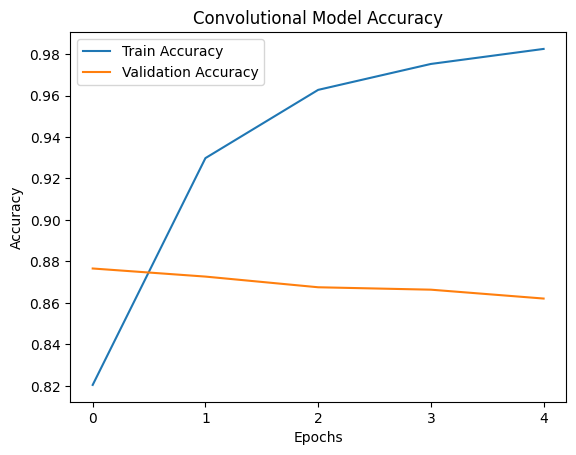

In [ ]:
plt.plot(history_conv.history['accuracy'], label='Train Accuracy')
plt.plot(history_conv.history['val_accuracy'], label='Validation Accuracy')
plt.title('Convolutional Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([0, 1, 2, 3, 4])
plt.legend()
plt.show()

# LSTM

In [ ]:
model_rnn = Sequential()
model_rnn.add(Input(shape=(max_seq_length,)))
model_rnn.add(Embedding(vocab_size, embedding_size, input_length=max_seq_length))
model_rnn.add(LSTM(128, return_sequences=True))
model_rnn.add(Dropout(0.5))
model_rnn.add(LSTM(64, return_sequences=True))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(32, return_sequences=False))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(num_classes, activation='softmax'))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 23, 100)           4005500   
                                                                 
 lstm (LSTM)                 (None, 23, 128)           117248    
                                                                 
 dropout_4 (Dropout)         (None, 23, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 23, 64)            49408     
                                                                 
 dropout_5 (Dropout)         (None, 23, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)               

In [ ]:
batch_size = 64
epochs = 5
with tf.device('/GPU:0'):
    history_rnn = model_rnn.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_sequences, test_labels))

Epoch 1/5
1506/1506 [==============================] - 313s 198ms/step - loss: 0.5318 - accuracy: 0.8002 - val_loss: 0.3550 - val_accuracy: 0.8750
Epoch 2/5
1506/1506 [==============================] - 263s 174ms/step - loss: 0.2661 - accuracy: 0.9070 - val_loss: 0.3672 - val_accuracy: 0.8702
Epoch 3/5
1506/1506 [==============================] - 256s 170ms/step - loss: 0.1919 - accuracy: 0.9341 - val_loss: 0.3973 - val_accuracy: 0.8751
Epoch 4/5
1506/1506 [==============================] - 262s 174ms/step - loss: 0.1509 - accuracy: 0.9479 - val_loss: 0.4126 - val_accuracy: 0.8714
Epoch 5/5
1506/1506 [==============================] - 253s 168ms/step - loss: 0.1199 - accuracy: 0.9593 - val_loss: 0.4712 - val_accuracy: 0.8643


In [ ]:
loss_lstm, accuracy_lstm = model_rnn.evaluate(test_sequences, test_labels)

753/753 [==============================] - 18s 24ms/step - loss: 0.4712 - accuracy: 0.8643


In [ ]:
predictions = model_rnn.predict(test_sequences)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(np.argmax(test_labels, axis=1), predicted_labels))

753/753 [==============================] - 24s 30ms/step
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      2943
           1       0.82      0.80      0.81      5134
           2       0.91      0.91      0.91      8032
           3       0.98      0.95      0.97      5674
           4       0.73      0.79      0.76      2300

    accuracy                           0.86     24083
   macro avg       0.83      0.84      0.83     24083
weighted avg       0.87      0.86      0.87     24083



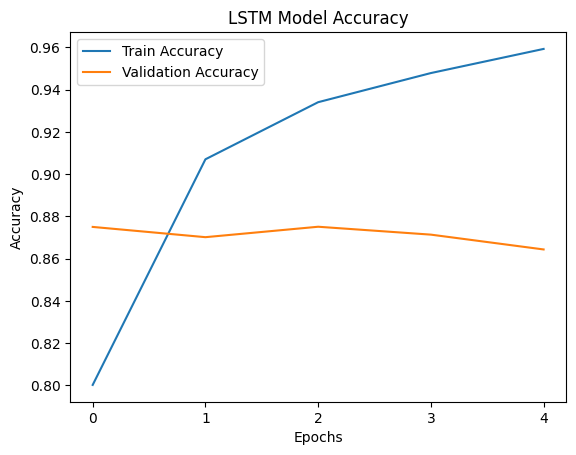

In [ ]:
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks([0, 1, 2, 3, 4])
plt.legend()
plt.show()